In [ ]:
!git clone https://github.com/bowman-aikium/aikium_thermal_stability
%cd aikium_thermal_stability

Cloning into 'aikium_thermal_stability'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 109 (delta 24), reused 98 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (109/109), 10.91 MiB | 16.57 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/aikium_thermal_stability


In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt

In [ ]:
from Model.model import thermalMLP, ProteinTmDataset

In [26]:
embedding_np = np.load("/content/esm2_embeddings_with_ids.npz", allow_pickle=True)
dataset_df = pd.read_csv("/content/aikium_thermal_stability/Data/Stratified_data.csv")

embedding = embedding_np["embeddings"]   # shape: (N, hidden_dim)
ids = embedding_np["ids"]

emb_df = pd.DataFrame({
    "ID": ids,
    "embedding": list(embedding)
})

emb_df["ID"] = emb_df["ID"].astype(int)
dataset_df["ID"] = dataset_df["ID"].astype(int)
merged = emb_df.merge(dataset_df, on="ID")
merged


,ID,embedding,Tm,Sequence,From,AA_length,MW
0,117012,"[3.4952238, 2.9369724, -3.406106, -1.0034976, ...",45.556042,MKWAYKEENNFEKRRAEGDKIRRKYPDRIPVIVEKAPKSKLHDLDK...,meltome,123,14.763731
1,313786,"[2.2217994, -2.0552912, -0.14634663, 1.3754547...",43.863329,MVKATNVDLSLEDIISKTRKTTGSIQKKSFGGARRGNTRPTGLPRR...,meltome,240,25.695370
2,169171,"[3.0030677, 4.205013, 4.074065, 0.7811, -6.895...",43.574470,MPRANEIKKGMVLNYNGKLLLVKDIDIQSPTARGAATLYKMRFSDV...,meltome,190,21.532381
3,227821,"[4.7244706, -0.123155594, 1.057647, 4.5875287,...",40.496359,MTKSELIERMLTKQPQLSAKDVELAVKTILDHMSQSLSTGERIEIR...,meltome,96,10.757199
4,97927,"[2.16275, -1.2902148, 2.1692014, 0.009807652, ...",37.073883,MRQVVLDTETTGIGAEKGHRIIEIGCVELIDRKLTGRHYHQYVNPQ...,meltome,234,26.063256
...,...,...,...,...,...,...,...
23415,200713,"[3.211512, 0.9198779, -0.08337058, -1.2356853,...",86.289547,MTVRQVLVHKGGGVHAIHPEATVLDALRKLAEHDIGALLVMEGERL...,meltome,143,15.916415
23416,267005,"[-1.4136505, -2.4800174, 0.06798242, 2.689519,...",88.057949,MTGLELLAVALGMRHGVDPDHLAAVDGLSRVRPSPLNGVLFALGHG...,meltome,220,22.874996
23417,269836,"[2.5266905, -5.975683, -3.1002605, 1.2522675, ...",88.583454,MASLSFMIKEYNDYYIIDFERPVRKFSSAPFNGGVGTSLRYINRTV...,meltome,215,24.262483
23418,298355,"[0.30273947, 2.1589444, -0.4573475, -0.4192088...",86.755190,MRFKAELMNAPEMRRALYRIAHEIVEANKGTEGLALVGIHTRGIPL...,meltome,181,20.466363


In [43]:
embeddings = np.stack(merged["embedding"].values)
Tm = merged["Tm"].values
input_dim = embeddings.shape[1]

X_train, X_val, y_train, y_val = train_test_split(embeddings, Tm, test_size=0.2, random_state=42)

all_ds = ProteinTmDataset(embeddings, Tm)
val_ds = ProteinTmDataset(X_val, y_val)

all_loader = DataLoader(all_ds, batch_size= 128 * 8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128 * 4)

In [31]:
model = thermalMLP(
    input_dim=input_dim,
    hidden_sizes=[1024, 512, 256],  # the config you used
    activation= nn.SiLU,
    dropout=0.0,
)

# Load weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("/content/aikium_thermal_stability/Training/Final training and model/best_model.pth"))
model = model.to(device)

R² Score: 0.9664
RMSE: 3.3700


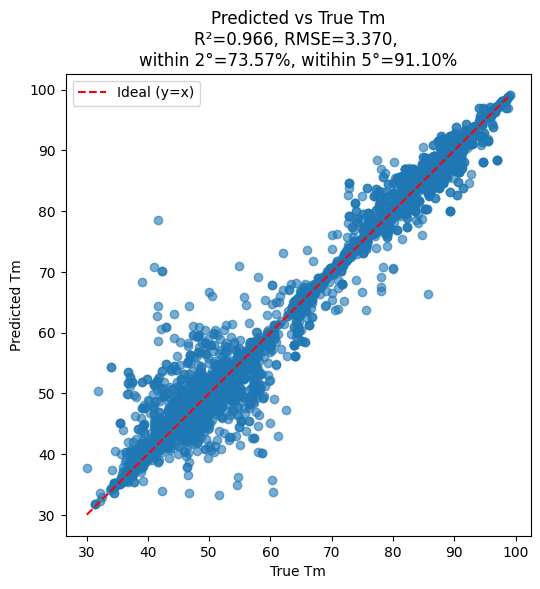

In [46]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def tolerance_accuracy(y_true, y_pred, tol=2.0):
    correct = np.abs(y_true - y_pred) <= tol
    return np.mean(correct) * 100

def plot_predictions(model, data_loader, device):
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)   # ✅ move data to the same device
            preds = model(xb).cpu().numpy()
            all_preds.extend(preds.flatten())
            all_true.extend(yb.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_true = np.array(all_true)

    within_2_deg = tolerance_accuracy(all_true, all_preds, tol=2.0)
    within_5_deg = tolerance_accuracy(all_true, all_preds, tol=5.0)
    r2 = r2_score(all_true, all_preds)
    mse = mean_squared_error(all_true, all_preds)
    rmse = np.sqrt(mse)

    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

    plt.figure(figsize=(6,6))
    plt.scatter(all_true, all_preds, alpha=0.6)
    plt.plot([min(all_true), max(all_true)], [min(all_true), max(all_true)],
             'r--', label="Ideal (y=x)")
    plt.xlabel("True Tm")
    plt.ylabel("Predicted Tm")
    plt.title(f"Predicted vs True Tm\nR²={r2:.3f}, RMSE={rmse:.3f}, \nwithin 2\u00b0={within_2_deg:.2f}%, witihin 5\u00b0={within_5_deg:.2f}%")
    plt.legend()
    plt.show()

# Example usage (after training or loading best_model_full.pth):
plot_predictions(model, val_loader, device)

R² Score: 0.9836
RMSE: 2.3507


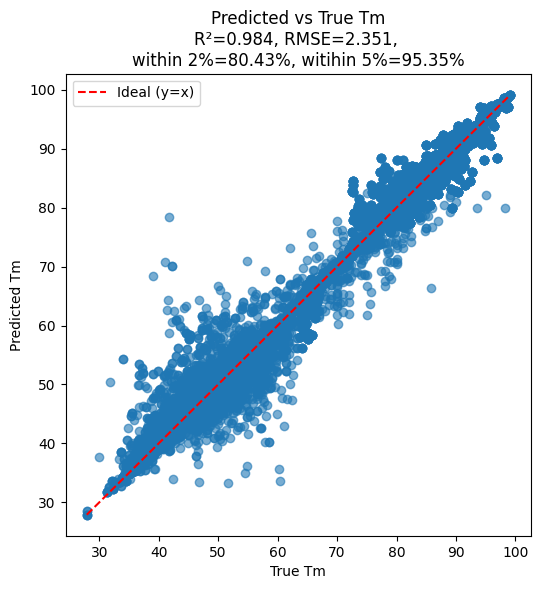

In [44]:
plot_predictions(model, all_loader, device)

NameError: name 'all_preds' is not defined

In [48]:
torch.save(thermalMLP, "best_model_with_params.pth")
from google.colab import files
files.download("best_model_with_params.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>